# Week 2: Summary statistics, similarity, and nearest neighbors  <span style="font-size: 0.3em;">v20260209a</span>

**Content:**
- Part 1: Summary statistics and measures of similarity
- Part 2: Nearest neighbors method in Python
- Part 3: Supervised learning on the Wine data
- Assignment 2: Similarity and kNN methods on the Whisky dataset

**Objectives:**
- Understand how to calculate summary statistics such as mean, variance, median, range, covariance and correlation.
- Understand the various measures of similarity, such as Jaccard and Cosine similarity and apply similarity measures to query for similar observations.
- Become familiar with fitting $k$-nearest neighbor models in Python.


## Commands and Methods Used in the Notebook

We will focus on two key libraries used for machine learning, namely NumPy (which we assume you already know) and scikit-learn (sklearn). We will use Pandas and dataframes to load and hold the data for easy access. **scikit-learn (sklearn)** is a popular Python library for machine learning that provides simple, consistent tools for training models and making predictions. In this assignment, it is used to apply standard machine learning algorithms without implementing them from scratch. 

The exercises use (or ask you to use) the following commands and methods:

- `numpy`
  - `np.array`: create a NumPy array
  - `np.load`: load `.npy` files
  - `np.mean`: average values
  - `np.std`: standard deviation (with `ddof` parameter for biased/unbiased)
  - `np.median`: median values
  - `np.min`: minimum value
  - `np.max`: maximum value
  - `np.sum`: sum of values
  - `np.dot`: dot product
  - `np.linalg.norm`: vector/matrix norm
  - `np.power`: elementwise exponentiation
  - `np.argsort`: indices that would sort an array
  - `np.unique`: find unique elements
  - `np.random.seed`: set random seed
  - `np.random.rand`: random values
  - `np.meshgrid`: create coordinate matrices
  - `np.corrcoef`: computes correlation matrix

- `pandas` (for loading and holding data, not for actual processing or analysis)
  - `pd.read_csv`: load CSV data

- `matplotlib.pyplot`
  - `plt.subplots`: create figures and axes
  - `plt.imshow`: show a matrix as an image
  - `plt.show`: display plots
  - `plt.xticks`: set x-axis tick labels
  - `plt.yticks`: set y-axis tick labels

- `seaborn`
  - `sns.set_style`: set plot style
  - `sns.set_theme`: set plot theme defaults

- `sklearn.metrics`
  - `confusion_matrix`: compute confusion matrix
  - `jaccard_score`: Jaccard similarity
  - `pairwise.cosine_similarity`: cosine similarity

- `sklearn.neighbors`
  - `KNeighborsClassifier`: k-nearest neighbors classifier
    - `.fit()`: train the classifier
    - `.predict()`: make predictions

- `sklearn.model_selection`
  - `train_test_split`: split data into train/test sets

- `scipy.stats`
  - `pearsonr`: Pearson correlation coefficient


In [ ]:
# Loading the basics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# Plotting style
sns.set_style('darkgrid')
sns.set_theme(font_scale=1.)

## Introduction

In this exercise, we start by taking a closer look on some of the building blocks of machine learning and statistical modeling, namely **summary statistics** and **similarity measures**. While summary statistics capture key properties of data and help us understand and compare datasets, similarity metrics such as cosine similarity and norm-based distances are essential for certain machine learning methods, e.g. **$k$-nearest neighbors (kNN)** (This week) and **decision trees (DCTs)** (Week6). In the final parts of the exercise, we will do **supervised learning** with kNNs on real datasets.

We first recap a few basic summary statistics and make sure you are comfortable computing these by hand and in Python. You may need to look up the definitions in the lecture notes.

**Task I.1:** Using pen and paper and a **basic** electronic calculator (e.g. on your computer), calculate the (empirical) mean, standard deviation (unbiased), median, and range of the following collection of numbers:
> $\mathbf{x}=[-0.68, -2.11,  2.39,  0.26,  1.46,  1.33,  1.03, -0.41, -0.33, 0.47]$

**Task I.2:** Verify your results by computing the same quantities with Python.
> *Hint:* Look at the help page of the functions `np.mean()`, `np.std()`, `np.median()`, `np.min()` and `np.max()`.

> *Hint:* You need to use 1 degree of freedom for the standard deviation - i.e. `std(..., ddof=1)`.

In [ ]:
x = np.array([-0.68, -2.11, 2.39, 0.26, 1.46, 1.33, 1.03, -0.41, -0.33, 0.47])

# I.2: Compute values, save in variables mean_x, std_x, median_x, range_x
# YOUR CODE HERE
raise NotImplementedError()

# Display results
print("Vector:", x)
print("Mean:", mean_x)
print("Standard Deviation:", std_x)
print("Median:", median_x)
print("Range:", range_x)

**Task I.3:** Compute both the unbiased and biased estimate of the standard deviation using `np.std()`. Are the two estimates the same? What is the difference?
> *Hint:* Consider what the argument `ddof=1` means.

In [ ]:
# I.3: Compute biased and unbiased estimate of the standard deviation, save as std_x_biased and std_x_unbiased

# YOUR CODE HERE
raise NotImplementedError()

# Display results
print("Biased Standard Deviation:", std_x_biased)
print("Unbiased Standard Deviation:", std_x_unbiased)


---
## Part 1: Using similarity measures to retrieve information

We will take a closer look at **similarity measures** and how they form the basis of information retrieval systems. Specifically, we examine how to extract the most similar items from a **database** given a **query** - a central mechanism in **recommender systems** that is used in everything from movie suggestions on Netflix to improved response generation in large language models (LLMs) such as ChatGPT. 

Specifically, we have a dataset of $N=9298$ handwritten digits (USPS handwritten digits database). <br>The images are of shape $16 \times 16$ pixels - the images have been "flattened" to store them as vectors, of size $M = 16\times 16 = 256$. 

The dataset therefore forms a matrix of size $(N,M) = (9298, 256)$.

$$
    \boldsymbol{X} = \begin{bmatrix} \boldsymbol{x}_1 \\ \boldsymbol{x}_2 \\ \vdots \\ \boldsymbol{x}_N \end{bmatrix} = \underbrace{ \begin{bmatrix} x_{1,1} & x_{1,2} & \cdots & x_{1,256} \\ x_{2,1} & x_{2,2} & \cdots & x_{2,256} \\ \vdots & \vdots & \ddots & \vdots \\ x_{N,1} & x_{N,2} & \cdots & x_{N,256} \end{bmatrix}}_{M}
$$
Hence, each attribute corresponds to a particular pixel in the image where its value defines the grayscale intensity of the pixel.

The goal is to match a **query image**, $\boldsymbol{q}$, to the images in the database $\boldsymbol{X}$, and extract the most similar one(s).

**Task 1.0:** Make sure you understand what the rows and columns of the above matrix correspond to before moving on.

**Task 1.1:** Check the associated data folder. Load the `digits.npy` file. 

> *Hint:* You can load `.npy`-files using `np.load(FILE_PATH)`.

In [ ]:
# Task 1.1: Load the digits dataset with np.load, save as "digits". 
# YOUR CODE HERE
raise NotImplementedError()

print("Shape of digits dataset:", digits.shape)
print("First sample:", digits[0])

As described, we will extract a datapoint from the dataset, as our **query image**, $\boldsymbol{q}$.

**Task 1.2:** Extract the first image and define it as the query vector, i.e. $\boldsymbol{q} = \boldsymbol{x}_1$. Make sure to remove the query image from the data matrix $\boldsymbol{X}$ accordingly.

> *Hint:* If in doubt, look up "NumPy Array Indexing".

> *Hint:* Make sure the query vector is of shape `(1, 256)` - for help, see `.reshape()` method. <br>You can use the `.shape` attribute to check the current shape of an array.

In [ ]:
# Task 1.2: Split the digits dataset into a query, q, and a set of images, X.
# YOUR CODE HERE
raise NotImplementedError()

# Check the shape of the digits dataset
assert X.shape == (9297, 16*16), "There should be 9298 samples and 16x16 = 256 features"
assert q.shape == (1, 16*16), "There should be 1 sample and 16x16 = 256 features"

We will now plot the query image, $\boldsymbol{q}$ and the first 4 images of $\boldsymbol{X}$ for you.

> *Hint:* Notice how we need to reshape the flattened image-vectors into matrices of size (16, 16) before plotting them, to make them look like images. 

In [ ]:
# Number of images to plot
plot_n_images = 5

# Setup figure
fig, axs = plt.subplots(1, plot_n_images, figsize=(4*plot_n_images,4))

# Plot the query image
axs[0].imshow(q.reshape(16, 16), cmap='gray')
axs[0].set_title(r'$\boldsymbol{q}$')
axs[0].axis('off')

# Plot the other images
for i in range(plot_n_images - 1):
    # Extract image number i (since numpy arrays are 0-indexed)
    digit = X[i].reshape(16, 16)  # Reshape to 16x16
    # Show image of digit
    axs[i+1].imshow(digit, cmap='gray')
    # Set title
    axs[i+1].set_title(rf"$\boldsymbol{{x}}_{{{i+1}}}$")
    # Remove axes
    axs[i+1].axis('off')
plt.show()


To measure similarity between $\boldsymbol{q}$ and the elements in $\boldsymbol{X}$, we will consider the measures SMC, Jaccard, Cosine, ExtendedJaccard, and Correlation, given by:
$$
\begin{align*}
  \mathrm{SMC}(\boldsymbol{q},\boldsymbol{x}_i)&=\frac{\text{Number of matching attribute values}}{\text{Number of attributes}} = \frac{\sum_{j=1}^M \mathbf{1}\left[x_{i,j} = q_j\right]}{M}\\ \\
  \mathrm{Jaccard}(\boldsymbol{q},\boldsymbol{x}_i)&=\frac{\text{Number of 11 matching attributes}}{\text{Number of attributes not involved in 00 matches}} = \frac{\sum_{j=1}^M \mathbf{1}\left[x_{i,j} = 1, q_{j} = 1\right]}{M - \sum_{j=1}^M  \mathbf{1}\left[x_{i,j} = 0, q_{j} = 0\right]  } 
\end{align*}
$$
$$
  \mathrm{Cosine}(\boldsymbol{q},\boldsymbol{x}_i) = \frac{\boldsymbol{q}^\top \boldsymbol{x}_i}{\|\boldsymbol{q}\|\|\boldsymbol{x}_i\|}, \quad \qquad
  \mathrm{ExtendedJaccard}(\boldsymbol{q},\boldsymbol{x}_i) = \frac{\boldsymbol{q}^\top \boldsymbol{x}_i}{\|\boldsymbol{q}\|^2+\|\boldsymbol{x}_i\|^2-\boldsymbol{q}^\top \boldsymbol{x}_i}, \qquad \quad
  \mathrm{Correlation}(\boldsymbol{q},\boldsymbol{x}_i) = \frac{\text{cov}(\boldsymbol{q},\boldsymbol{x}_i)}{\text{std}(\boldsymbol{q})\text{std}(\boldsymbol{x}_i)}
$$
where $\mathbf{1}\left[x_{i,j} = q_j\right]$ denotes the indicator function, $\displaystyle\mathrm{cov}(\boldsymbol{x},\boldsymbol{y})$ denotes the covariance between $\boldsymbol{x}$ and $\boldsymbol{y}$ and $\text{std}(\boldsymbol{x})$ denotes the standard deviation of $\boldsymbol{x}$.

The SMC and Jaccard similarity measures are only defined for binary data, i.e., data that takes values of $\{0,1\}$. As the
data we analyze is non-binary *(Notice how some of the pixels are not completely black or white?)*, we will transform the data to be binary when calculating these two measures of similarity by thresholding according to the median per-pixel intensity, i.e. setting
$$
  x_{i,j}=\left\{\begin{array}{ll} 0 & \mathrm{if}\ x_{i, j}<\mathrm{median}(\boldsymbol{X}_{:, j}) \\
    1 & \mathrm{otherwise}\end{array} \right.
$$
*Note that, depending on the situation, it can be incorrect to encode information in a single binary attribute - and this is true for binary attributes in general. If the meaning behind the value 0 is not specifically non-presence of an attribute, it can be erroneous. For instance, if male/female is encoded in one binary attribute (male: 0, female: 1), some measures will not model the information carried in being male, and a one-of-out-K encoding would be a proper representation.*

**Task 1.3:** Compute the median per-pixel intensity for the images in $\boldsymbol{X}$, save as `median_per_pixel`. 

> *Hint:* What should you set the `axis` argument to when using `np.median()`? <br> Do we want the median of all pixels per image, or the median of each pixel across all images?

In [ ]:
# Task 1.3: Compute the median per pixel
# YOUR CODE HERE
raise NotImplementedError()

assert median_per_pixel.shape == (256,)

**Task 1.4:** Binarize the images and the query using the above criteria, save them as `X_binarized` and `q_binarized`.

> *Hint:* You can construct a boolean mask using the `>` operator to compare the images with the median per pixel. This will create a list of True and False, stating whether each pixel is above the threshold or not. 

> *Hint:* Then use `.astype(int)` to convert the boolean arrays to binary (ones and zeros) image arrays.

In [ ]:
# Task 1.4: Binarize the images, save as X_binarized and q_binarized

# YOUR CODE HERE
raise NotImplementedError()

# Check if all values are binary
assert all(np.unique(X_binarized) == [0, 1]), "X_binarized should be binary..."
assert all(np.unique(q_binarized) == [0, 1]), "q_binarized should be binary"

We now plot the first 5 samples (when including the query).

In [ ]:
# Create figure
fig, axs = plt.subplots(1, 5, figsize=(20,4))

# Plot the query image
axs[0].imshow(q_binarized.reshape(16, 16), cmap='gray')
axs[0].set_title(r'$\boldsymbol{q}$')
axs[0].axis('off')

for i in range(plot_n_images - 1):
    # Extract image number i
    digit = X_binarized[i].reshape(16, 16)  # Reshape to 16x16
    # Show image of digit
    axs[i+1].imshow(digit, cmap='gray')
    # Set title
    axs[i+1].set_title(rf"$\boldsymbol{{x}}_{i}$")
    # Remove axes
    axs[i+1].axis('off')
plt.show()

**Task 1.5:** Implement at least two of the similarity measures presented above as python functions. Use them to compute the similarity between $\boldsymbol{q}_{\text{binarized}}$ and each image in $\boldsymbol{X}_{\text{binarized}}$.

> *Hint:* The functions `np.sum()`, `np.dot()`, `np.linalg.norm()` and `np.power()` might be useful.

> *Hint:* Give it an honest try! But if it's really difficult, check out `sklearn.metrics.pairwise.cosine_similarity`, `sklearn.metrics.jaccard_score` or `scipy.stats.pearsonr`.

> *Hint:* Make sure to remove any similarity functions that you have not implemented from the `similarity_functions` list at the bottom in the cell below.

In [ ]:
# Task 1.5: Implement at least 2 of the following similarity functions.

def smc(q, X):
    # q: the binarized query vector of shape (1 x M)
    # X: a set of binarized database vectors of shape (N x M)
    M = X.shape[1]

    # YOUR CODE HERE
    raise NotImplementedError()
    
    return similarity_score

def jaccard(q, X): # or alternatively using sklearn.metrics.jaccard_score
    # q: the binarized query vector of shape (1 x M)
    # X: a set of binarized database vectors of shape (N x M)
    M = X.shape[1]

    # YOUR CODE HERE
    raise NotImplementedError()
    return similarity_score

def cosine(q, X):
    # q: the query vector of shape (1 x M)
    # X: a set of database vectors of shape (N x M)

    # YOUR CODE HERE
    raise NotImplementedError()
    return similarity_score

def extended_jaccard(q, X):
    # q: the query vector of shape (1 x M)
    # X: a set of database vectors of shape (N x M)

    # YOUR CODE HERE
    raise NotImplementedError()
    return similarity_score

def correlation(q, X):
    # q: the query vector of shape (1 x M)
    # X: a set of database vectors of shape (N x M)

    # YOUR CODE HERE
    raise NotImplementedError()
    return similarity_score

# Remove any similarity-functions that you have not implemented from the list below:
similarity_functions = [smc, jaccard, cosine, extended_jaccard, correlation]

We provide code for visualizing the most similar images to the query, $\boldsymbol{q}$, that will run once you implement some of the similarity measures. 

**Task 1.6:** Read your way through the code for plotting the results. You have to write a single line to get `most_similar_order` that should contain the indexes from $[1, 2, \dots N]$ sorted according to the similarity measure in descending order.

> *Hint:* Check out `np.argsort()` for getting the indices in sorted order. Is it sorted in ascending or descending order?

> *Hint:* You can reverse the elements of an array by using `x[::-1]`. Hence if `x = [1, 2, 3]`, then `x[::-1]` is `[3, 2, 1]`. 

In [ ]:
# Define the number of top results to retrieve
top_k = 5

# Initialize figure
fig = plt.figure(figsize=(3*top_k, 3*(len(similarity_functions)+1)))
# Plot the query image
ax = fig.add_subplot(len(similarity_functions)+1, 1, 1)
ax.imshow(q_binarized.reshape(16, 16), cmap='gray')
ax.set_title(r'$\boldsymbol{q}$')
ax.grid(False)
plot_idx = top_k + 1 # update plot index

# Iterate over the similarity functions and compute similarities
for sim_func in similarity_functions:
    # Compute similarities using the binarized images and query
    similarities = sim_func(q_binarized, X_binarized)
    
    # Task 1.6: Use np.argsort to sort the similarities in descending order - save as "most_similar_order"
    # YOUR CODE HERE
    raise NotImplementedError()

    # Sort the images in the database
    sorted_images = X[most_similar_order]

    # Plot the top-k most similar images under the corresponding similarity function
    for k in range(top_k):
        # Create subplot for each image
        ax = fig.add_subplot(len(similarity_functions)+1, top_k, plot_idx)
        # Plot the image
        ax.imshow(sorted_images[k].reshape(16, 16), cmap='gray')
        # Set a title
        ax.set_title(f'image #{most_similar_order[k]}\nSimilarity: {similarities[most_similar_order[k]]:.2f}')
        ax.grid(False)

        # Add y-label if it's the first image in the row
        if k == 0:
            ax.set_ylabel(f'{sim_func.__name__.capitalize().replace("_", " ")}')

        # Update plot index
        plot_idx += 1

fig.tight_layout()
plt.show()

Congratulations! <br> If your implementation is correct, we should be able to retrieve somewhat reasonable images using either of the measures and we have the basis of a recommender system.

**Task 1.7:** Try to change the query image to e.g. $\boldsymbol{q}=\boldsymbol{x}_{13}$ (In Task 1.2). <br>Are the retrieved images still related to the query? Argue why / why not?

> *Hint:* Make sure you remove the query image from X.

- *Answer:* 

**Task 1.8:** How does the *least* similar images look? And what happens if you use $\boldsymbol{X}$ and $\boldsymbol{q}$ instead of $\boldsymbol{X}_{\text{binarized}}$ and $\boldsymbol{q}_{\text{binarized}}$ when computing the similarities?

- *Answer:* 

> *Hint:* Don't reverse the order of the argsort you implemented previously.

We will now investigate how scaling and translation impact the following three similarity measures: Cosine, ExtendedJaccard, and Correlation. 

**Task 1.9:** (Pen and Paper) Let $\alpha$ and $\beta$ be two constants. Determine which of the following statements are correct (you may need to use pen and paper). You can verify your statements with a coding example, we have provided a synthetic dataset in the code-cell below (x, y, a, b).

$$
\begin{align*}
  \mathrm{Cosine}(\boldsymbol{x},\boldsymbol{y})&=\mathrm{Cosine}(\alpha\boldsymbol{x},\boldsymbol{y}) \\
  \mathrm{ExtendedJaccard}(\boldsymbol{x},\boldsymbol{y})&=\mathrm{ExtendedJaccard}(\alpha\boldsymbol{x},\boldsymbol{y}) \\
  \mathrm{Correlation}(\boldsymbol{x},\boldsymbol{y})&=\mathrm{Correlation}(\alpha\boldsymbol{x},\boldsymbol{y}) \\
  \mathrm{Cosine}(\boldsymbol{x},\boldsymbol{y})&=\mathrm{Cosine}(\beta+\boldsymbol{x},\boldsymbol{y}) \\
  \mathrm{ExtendedJaccard}(\boldsymbol{x},\boldsymbol{y})&=\mathrm{ExtendedJaccard}(\beta+\boldsymbol{x},\boldsymbol{y}) \\
  \mathrm{Correlation}(\boldsymbol{x},\boldsymbol{y})&=\mathrm{Correlation}(\beta+\boldsymbol{x},\boldsymbol{y}) \\
\end{align*}
$$

> *Hint:* Even though a similarity measure is theoretically invariant e.g. to scaling, it might not be exactly invariant numerically.

**Task 1.10:** Discuss the pratical implications of similarity measures that are translation and/or scaling invariant. You can base the discusison on the image digits dataset but think also of non-image example (e.g. retrieving documents based on the bag-of-words representation from last weeks exercise).

In [ ]:
np.random.seed(42)

# Generate two data objects with M random attributes
M = 5
x = np.random.rand(1, M)
y = np.random.rand(1, M)

# Two constants
a = 1.5
b = 1.5

# Check the statements by computing LHS and RHS of the statements
# YOUR CODE HERE
raise NotImplementedError()


---
## Part 2: Nearest neighbors method in Python

In this exercise we will use the $k$-nearest neighbors (KNN) method for classification. First, we will explore how $k$-nearest neighbors work for 4 different synthetic datasets and how the choice of distance/dissimilarity measure used matters, depending on the dataset. We will consider *training* our $k$-nearest neighbors on a *training set* split of the dataset and later evaluate the learned model on a *test set* split of the dataset where we already split the datasets for you.

**Task 2.1:** Examine the loaded `synth1_train.csv` and `synth1_test.csv` files using Pandas.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

From the datasets, construct $\left(\boldsymbol{X}_{\text{train}}, \boldsymbol{y}_{\text{train}}\right)$ and $\left(\boldsymbol{X}_{\text{test}},\boldsymbol{y}_{\text{test}}\right)$.

> *Hint:* Remember how we split the dataframes into X and y in last weeks exercise? Which column-names corresponds to the attributes, and which column-name corresponds to the target label?

In [ ]:

# Task 2.1: Load the dataset splits and construct the datamatrices X_train, X_test and target vectors y_train, y_test
# YOUR CODE HERE
raise NotImplementedError()

# Check that the input shapes are correct
assert X_train.shape[1] == 2, f"Expected 2 features, but got {X_train.shape[1]}"
assert X_test.shape[1] == 2, f"Expected 2 features, but got {X_test.shape[1]}"

Since the data is 2-dimensional, we can examine it closer by making a scatter plot of the points. We make a scatter plot of the points from the training data by directly leveraging Pandas' plotting tools and color the points based on their labels.

In [ ]:
# Visualize the training data, colored by the target variable
df_train.plot(kind='scatter', x='x0', y='x1', c='y', cmap='viridis', title=f'Training set: {dataset_name}', figsize=(8, 6), edgecolor='gray')
plt.show()

For creating a classification model using $k$-nearest neighbors we need to define what it means to be close neighbors - or in other words, **how we define similarity between points**. More specifically, we need to choose:
- the number of neighbors, $k$
- a distance measure, $d(\boldsymbol{x}_i, \boldsymbol{x}_j)$

We remark that distance measures are inversely related to similarity measures by definition. As an example, we can convert cosine similarity to a distance measure by $1 - \mathrm{Cosine}(\boldsymbol{x}_i, \boldsymbol{x}_j)$ since the maximum cosine similarity is 1. <br>I.e. the smaller the cosine similarity, the larger the distance.

If we want to classify some new observation, $\boldsymbol{x}^\ast$, using $k$-nearest neighbors, we then have to:
1) compute the distance from $\boldsymbol{x}^\ast$ to all points, $\boldsymbol{x}_i$, from the training data, i.e. $d(\boldsymbol{x}^\ast, \boldsymbol{x}_i)$ where $\boldsymbol{x}_i$ is the $i$'th row in $\boldsymbol{X}_{\text{train}}$.
2) find the $k$ nearest data points in $\boldsymbol{X}_{\text{train}}$ and get their labels.
3) classify $\boldsymbol{x}^\ast$ according to the majority label of the $k$ nearest neighbors.

As you have seen in the lecture, a common distance measure is the **general Minkowski distance** also known as the **$p$-norm**:
$$
    d_p\left(\boldsymbol{x}^\ast, \boldsymbol{x}\right) = \left( \sum_{j=1}^M \lvert x^\ast_j - x_{j}\rvert^p\right)^{\frac{1}{p}}
$$
which reduces to the cityblock (or Manhattan) distance for $p=1$ and the Euclidean distances for $p=2$:
$$
\begin{align*}
    \text{Cityblock}: \ d_1\left(\boldsymbol{x}^\ast, \boldsymbol{x}\right) = \sum_{j=1}^M \lvert x^\ast_j - x_{j}\rvert \qquad \qquad
    \text{Euclidean}: \ d_2\left(\boldsymbol{x}^\ast, \boldsymbol{x}\right) = \sqrt{\sum_{j=1}^M \lvert x^\ast_j - x_{j}\rvert^2}
\end{align*}
$$

We will now show you how to use the `KNeighborsClassifier` from `sklearn`, to train a $k$-Nearest Neighbors classifier on our dataset. <br>We will use $k=5$ neighbours and base the distance on euclidean distance. 

In [ ]:
# Define number of neighbours
k = 5

# Create the model object with the specific hyperparameters
model = KNeighborsClassifier(n_neighbors=k, metric='euclidean')

# "Train" the model by giving it the training data
model.fit(X_train, y_train) # i.e. the attributes and the labels.

**Task 2.2:** Consider a new observation $\boldsymbol{x}^\ast = [1, -1]^\top$. Which label would you assign to this point based on the training data?

> *Hint:* Take a look at the scatter plot of the training data above. 

- *Answer:*


**Task 2.3:** Use `KNeighborsClassifier` from `sklearn` to classify the new observation, save the predicted label in a variable called `y_pred`. <br> Does the predicted label match your answer from Task 2.2?

> *Hint:* Use model.predict(). Checkout the documentation for `sklearn.neighbors.KNeighborsClassifier` if you need more information.

- *Answer:*

In [ ]:
k = 5
X_new = np.array([[1, -1]])

# Task 2.3: Make predictions on the new observation X_new, save the result in y_pred.
# YOUR CODE HERE
raise NotImplementedError()

print(f"y_pred is predicted to have label {y_pred.item()}.")

We have provided a plot of the training data, and the new observation $\boldsymbol{x}_{\text{new}}$ in the plot below. <br> The plot should also show the $k$ closest neighbors to $\boldsymbol{x}_{\text{new}}$ - you need to implement this.

**Task 2.4:** Find the closest neighbors to $\boldsymbol{x}_{\text{new}}$ and their labels, save them as `closest_neighbors` and `closest_labels`.

> *Hint:* You can find the indices of the closest neighbors using the `closest_neighbors_indices = model.kneighbors(X_new, n_neighbors=k, return_distance=False).flatten()`

> *Hint:* Use the indices to find the closest neighbors and their labels, by indexing the training data and labels, X_train and y_train.

In [ ]:
# Task 2.4: Find the closest neighbors to the new point and their labels, save them as "closest_neighbors" and "closest_labels".
# YOUR CODE HERE
raise NotImplementedError()

# Visualize the training data, colored by the target variable
df_train.plot(kind='scatter', x='x0', y='x1', c='y', cmap='viridis', title=f'Training set: {dataset_name}', figsize=(8, 6), edgecolor='gray')

# Plot the new point and its closest neighbors
plt.scatter(X_new[0, 0], X_new[0, 1], color='red', marker='o', s=50, label='New Point')
plt.scatter(closest_neighbors[:, 0], closest_neighbors[:, 1], color='k', marker='x', s=50, label='Closest Neighbors')
plt.legend()
plt.show()

print(f"Closest labels: {closest_labels}")

We are interested in determining how well this classification method works. To do so, we use it to classify the test dataset $\boldsymbol{X}_{\text{test}}$ and compare the predictions with the true test labels $\boldsymbol{y}_{\text{test}}$.

**Task 2.5:** Compute the predicted labels for all data points in $\boldsymbol{X}_{\text{test}}$, save them as `y_pred`.

> *Hint:* The `model.predict`-method works both on individual data points and on entire datasets.

In [ ]:
# Task 2.5: Predict using the model, save the predictions in y_pred
# YOUR CODE HERE
raise NotImplementedError()
print(f"Predictions: {y_pred}")

We now compute the accuracy and error rate. 

**Task 2.6:** Compute the accuracy and error rate of the model, save them as `accuracy` and `error_rate`.

> *Hint:* You can compare `y_test` and `y_pred` with the `==` operator, this returns a boolean array of whether each element is equal. You can then use the `np.mean()` function to compute how often the model predicted the correct class.

> *Hint:* Computing the error rate is quite simple - How does the error rate relate to the accuracy?

In [ ]:
# Task 2.6: Compute the accuracy and error rate, save them as accuracy and error_rate.
# YOUR CODE HERE
raise NotImplementedError()

print("Accuracy: {0}%".format(accuracy * 100))
print("Error rate: {0}%".format(error_rate * 100))


**Task 2.7:** Generate the confusion matrix, save it as `cm`. We will handle the plotting. <br>How well does the model perform? Does it perform specifically better/worse on some classes than others?

> *Hint:* To generate a confusion matrix, you can use the function `confusion_matrix()` function from the `sklearn.metrics` module. <br> You can find the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

In [ ]:

# Task 2.7: Compute the elements of the confusion matrix
# YOUR CODE HERE
raise NotImplementedError()

# Plot the confusion matrix
fig = plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap="binary", interpolation="None")
plt.colorbar()
plt.xticks(np.unique(y_test))
plt.yticks(np.unique(y_test))
plt.xlabel("Predicted class")
plt.ylabel("Actual class")
plt.title("Confusion matrix (Accuracy: {0}%, Error Rate: {1}%)".format(accuracy, error_rate))
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.grid(False)
plt.show()

In addition to this, we might be able to say something qualitatively about the model's performance by visualizing the **decision boundary** - that is how the 2D input space is separated by the $k$-nearest neighbors model. <br> We can do so, by predicting the label for every input point $\boldsymbol{x}^\ast$ in a fine grid over the input space. 

In the code below, we define the grid of $500\times500$ points over the input space and stack them into the data matrix format of shape $(500 \times 500)\times 2$. We can then predict on our data-matrix, `X_grid`, and store the predicted labels in `y_pred` - that'll be your job. 

**Task 2.5:** Visualize the decision boundary by predicting the label for every input point $\boldsymbol{x}^\ast$ in `X_grid` and storing the predicted labels in `y_pred`. Then reshape the predicted labels into shape `resolution` $\times$ `resolution`, such that they can be visualized using `plt.imshow()`. 

> *Hint:* Apply your $k$-nearest neighbors model to every point on the grid and store the labels. Then reshape the predicted labels into shape `resolution` $\times$ `resolution` and plot the decision boundary using `plt.imshow()`. 

In [ ]:
# Define resolution of the grid, i.e. how many points per axis
resolution = 500
# Construct the grid
min_x0, max_x0 = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
min_x1, max_x1 = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
X_grid = np.meshgrid(
    np.linspace(min_x0, max_x0, resolution),
    np.linspace(min_x1, max_x1, resolution)
)
# Stack the grid points into the format of X, i.e. shape N x M
X_grid = np.stack([X_grid[0].ravel(), X_grid[1].ravel()]).T

# Task 2.5: Predict the labels for the grid points, save as y_pred
# YOUR CODE HERE
raise NotImplementedError()


# Plot the decision boundary
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title('Decision boundary of kNN')
ax.imshow(y_pred, extent=(min_x0, max_x0, min_x1, max_x1), origin='lower', alpha=0.5, cmap='viridis')
# Plot the training points
df_train.plot(kind='scatter', x='x0', y='x1', c='y', cmap='viridis', ax=ax, edgecolors='gray', colorbar=False, label='Training data')
df_test.plot(kind='scatter', x='x0', y='x1', c='y', cmap='viridis', ax=ax, edgecolors='gray', colorbar=False, marker='s', label='Test data')
ax.set_aspect('auto')
ax.grid(False)
plt.show()


**Task 2.6:** Go back and experiment with the distance measure and number of neighbors and run the experiment for the other synthetic datasets too. As distance measures, consider cityblock, Euclidean and cosine as discussed in Part 1 (specifically useful for the `synth2` dataset). Which distance measures worked best for the four problems? Can you explain why? How many neighbors were needed for the four problems? Can you give an example of when it would be good to use a large/small number of neighbors? Consider e.g. when clusters are well separated versus when they are overlapping.

> *Hint:* For `synth3` you might find the Mahalanobis distance useful. Use `model = KNeighborsClassifier(n_neighbors=k, metric='mahalanobis', metric_params={'V': np.cov(X_train, rowvar=False)})` for doing so. You can find further details on this distance metric [on this link](https://en.wikipedia.org/wiki/Mahalanobis_distance).

- *Answer:* 

### Regression with $k$-nearest neighbors

In the previous example we used $k$-nearest neighbors for solving a classification problem, but the method can just as well be used for modeling a regression task. We follow a similar algorithmic approach as before when predicting the regression output of a new observation, $\boldsymbol{x}^\ast$, that is:
1) compute the distance from $\boldsymbol{x}^\ast$ to all points, $\boldsymbol{x}_i$, from the training data, i.e. $d(\boldsymbol{x}^\ast, \boldsymbol{x}_i)$ where $\boldsymbol{x}_i$ is the $i$'th row in $\boldsymbol{X}_{\text{train}}$.
2) find the $k$ nearest data points in $\boldsymbol{X}_{\text{train}}$ and get the associated target attribute values from $\boldsymbol{y}_{\text{train}}$.
3) average the associated target attribute values of the $k$ nearest neighbors as the predicted output.

We provide a simple example in 1D below for a sinusoidal function with noisy observations in the range $x\in[0,1]$. First, we compute the prediction of $x^\ast = 0.5$ and show its $k=5$ nearest neighbors. Next, we compute predictions for a fine grid of points in the range of $x$ and plot the results as our **approximated function**. 

**Task 2.7:** Read your way through the code and understand the details of this toy experiment.

In [ ]:
np.random.seed(42)  # for reproducibility

# Experiment parameters
k = 5                       # number of neighbors
N = 20                      # number of points
observation_noise = 0.25    # standard deviation of observation noise

# Define the true (unseen) function
def sine_function(x, frequency: int = 5):
    return np.sin(frequency * x)

# Define a new test point
X_new = np.array([[0.5]])

# Generate training data
X_train = np.random.rand(N, 1) # Sample training data points
y_train = sine_function(X_train) + np.random.normal(0, observation_noise, (N, 1)) # Get target values for training points, with observation noise

# Compute the steps of k-nearest neighbors
# Note that all general Minkowski distances can be computed using the same method in 1D - can you argue why?
distances = np.linalg.norm(X_train - X_new, axis=1)
most_similar_idxs = np.argsort(distances)[:k]  # Get the indices of the k nearest neighbors
y_pred = y_train[most_similar_idxs].mean()  # Predict the output for the new input

# Make a subplot layout
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)

# Plot training data
axs[0].plot(X_train, y_train, 'o', label='Training data') 
# Plot the results of kNN for a single point
axs[0].vlines(X_new, ymin=y_train.min(), ymax=y_train.max(), color='r', linestyle='--', label=fr'New point, $x^\ast={X_new.item()}$')
# Highlight the nearest neighbors
axs[0].plot(X_train[most_similar_idxs], y_train[most_similar_idxs], 'o', color='orange', label=f'$k$={k} nearest neighbors') 
# Plot the predicted value
axs[0].plot(X_new, y_pred, 'ro', mec='k', label=fr'Predicted value, $\hat{{y}}={y_pred.item():.2f}$') 
# Plot the true function
axs[0].plot(np.linspace(0, 1, 100), sine_function(np.linspace(0, 1, 100)), label='True function', color='k') 
# Add figure layout elements
axs[0].set_title('kNN in 1D (single point example)')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].legend()


# Now we run the same computation but for a fine grid of test points in the interval [0, 1]
X_pred = np.linspace(0, 1, 1000).reshape(-1, 1)  # Create a grid of test points
distances = np.linalg.norm(X_train[None, :] - X_pred[:, None], axis=2) # vectorized version of computing distances for all test points at once
most_similar_idxs = np.argsort(distances, axis=1)[:, :k]  # Get the indices of the k nearest neighbors for each test point
y_pred = y_train[most_similar_idxs].mean(axis=1)  # Predict the output for each test point

# Plot the results of kNN on the range [0,1]
# Plot training data
axs[1].plot(X_train, y_train, 'o', label='Training data') 
# Plot the true function
axs[1].plot(np.linspace(0, 1, 100), sine_function(np.linspace(0, 1, 100)), label='True function', color='k') 
# Plot the predicted function in the range x in [0,1]
axs[1].plot(X_pred, y_pred, label='Aprroximated function', color='red') 
axs[1].set_title(r'Approximated function by kNN, $x^\ast \in [0,1]$')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].legend()
plt.show()

**Task 2.7:** Can you explain why the approximated function is a step-wise function? Experiment with the number of neighbors $k$ - what happens if $k=1$ or $k=10$? What happens to the approximate function if you increase the number of samples to $N=200$ in combination with $k=20$? Can you explain what happens to the quality of the fit and why?

- *Answer:*

In general we can use a concept called **cross-validation** to select the optimal distance metric and number of nearest neighbors $k$ although this can be computationally expensive. We will cover this topic in detail in week 6. 


---
## Part 3: KNN Classification on Wine data


<div style="display: flex; align-items: flex-start;">

<div style="flex: 1; padding-right: 5em;">

We will in this part of the exercise consider two datasets related to red and white variants of the Portuguese "Vinho Verde" wine, the data has been downloaded from [this website](http://archive.ics.uci.edu/ml/datasets/Wine+Quality). Only physicochemical and sensory attributes are available, i.e., there is no data about grape types, wine brand, wine selling price, etc. You can see the attributes of the data in the provided table. Attributes 1–11 are based on physicochemical tests and attribute 12 on human judging. 

The aim of this exercise is to implement a machine learning pipeline for classifying the color of the wine. We will use visualization and distance measurements to identify outliers and remove these outliers from the data. It might be necessary to remove some outliers before other outlying observations become visible. Thus, the process of finding and removing outliers is often iterative.

</div>

<div style="flex: 0 0 350px;">
<table>
<thead>
<tr>
<th>#</th>
<th>Attribute</th>
<th>Unit</th>
</tr>
</thead>
<tbody>
<tr><td>1</td><td>Fixed acidity (tartaric)</td><td>g/dm³</td></tr>
<tr><td>2</td><td>Volatile acidity (acetic)</td><td>g/dm³</td></tr>
<tr><td>3</td><td>Citric acid</td><td>g/dm³</td></tr>
<tr><td>4</td><td>Residual sugar</td><td>g/dm³</td></tr>
<tr><td>5</td><td>Chlorides</td><td>g/dm³</td></tr>
<tr><td>6</td><td>Free sulfur dioxide</td><td>mg/dm³</td></tr>
<tr><td>7</td><td>Total sulfur dioxide</td><td>mg/dm³</td></tr>
<tr><td>8</td><td>Density</td><td>g/cm³</td></tr>
<tr><td>9</td><td>pH</td><td>pH</td></tr>
<tr><td>10</td><td>Sulphates</td><td>g/dm³</td></tr>
<tr><td>11</td><td>Alcohol</td><td>% vol.</td></tr>
<tr><td>12</td><td>Quality score</td><td>0–10</td></tr>
</tbody>
</table>
</div>

</div>

**Task 3.1:** Load the wine dataset from the associated data folder. Construct the data matrix $\boldsymbol{X}$ and the target attribute $\boldsymbol{y}$ where the target attribute is the wine color, `Color`.


In [ ]:
# Task 3.1: Load the wine dataset, split into attributes, X, and labels, y.
# YOUR CODE HERE
raise NotImplementedError()

assert X.shape == (6497, 12), "There should be 6497 samples and 12 features in the wine dataset"
assert y.shape == (6497,), "There should be 6497 labels in the wine dataset"

X.head()

**Task 3.2:** Plot a boxplot of each attribute in $\boldsymbol{X}$ and compute summary statistics of the data matrix $\boldsymbol{X}$. What does the mean vs. median for the "Alcohol" attribute tell you?

> *Hint:* Remember that since `X` is a Pandas dataframe, you can do `X.plot(kind='box')`. <br> You might want to check the [documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html) of the `plot` method of a Pandas dataframe - specifically the arguments `subplots` and `layout` to make the boxplots look better.

> *Hint:* Consider using the Pandas method `.describe()` - it computes several summary statistics at once.

In [ ]:
# Task 3.2: Plot a boxplot of the attributes in X, and compute summary statistics
# YOUR CODE HERE
raise NotImplementedError()

As you can hopefully see from the boxplot and summary statistics, the dataset has many observations that can be considered outliers and in order to carry out analyses later it is important to remove the corrupted observations, e.g. $10^{15}$ is clearly not a proper value for alcohol content! However, it is impossible to see the distribution of the data, because the axis is dominated by these extreme outliers. Say we expect volatide acidity (VA) to be around $0-2 \textrm{g}/\textrm{dm}^3$, density (D) to be close to $1 \textrm{g}/\textrm{cm}^3$, and alcohol percentage (AP) to be somewhere between $5-20\% \textrm{vol}$. We can use this knowledge to define wines with VA $> 2$, D $> 1$ and AP $> 20$ as outliers.

Below, we have defined a mask that marks the outliers, based on our expert assumption. 

**Task 3.3:** Remove outliers from $\boldsymbol{X}$ and $\boldsymbol{y}$ by applying the inverted mask. Show the boxplot for each attribute after removing these outliers. 

> *Hint:* Pandas allows for logical conditions like `(df['Alcohol'] > 20)` to identify rows with outliers. Combine multiple conditions using the `|` operator (logical OR), and wrap each condition in parentheses. To remove the outliers, consider using the `~` operator to invert the filter.

> *Hint:* You can use a mask to index outlier observations by e.g. writing `X=X[mask,:]` and `y=y[mask]` where `mask` indicates the data objects that should be maintained. In our case, the mask is outliers, and should therefore be inverted. 


In [ ]:
# Get the boolean mask for outlier detection
mask = (X['Volatile acidity'] > 2) | (X['Density'] > 1) | (X['Alcohol'] > 20)

# Task 3.3: Use the mask to remove the outliers from X and y. Plot a boxplot like you did in the previous task. 
# YOUR CODE HERE
raise NotImplementedError()

assert X.shape == (6304, 12), "There should be 6304 samples and 12 features in the wine dataset after outlier removal"
assert y.shape == (6304,), "There should be 6304 labels in the wine dataset after outlier removal"

We will now attempt to classify the type of wine i.e. white or red (and later also the quality score) based on the physicochemical tests. Visual inspection of the data can give an indication of the difficulty of these tasks. In the following code cell, we plot a matrix scatter plot for all attributes.

In [ ]:
# Number of attributes
M = X.shape[1]

# Plot a matrix scatter plot of the wine attributes, colored by the wine color
fig, axs = plt.subplots(M, M, figsize=(20, 20), sharex='col', sharey='row')
for i in range(M):
    for j in range(M):
        for color in y.unique(): # loop through each label
            # Construct a mask based on the label
            mask = (y == color)
            # Plot the scatter plot for attribute pair (if not on the diagonal)
            axs[i, j].scatter(
                x=X[mask].iloc[:, j],        # x-values for the $j$'th attribute
                y=X[mask].iloc[:, i],        # y-values for the $i$'th attribute
                label=color, alpha=0.3,
                color='r' if color == 'Red' else 'y'
            )

# Update titles
for col in range(M):
    axs[0, col].set_title(X.columns[col])
    axs[col, 0].set_ylabel(X.columns[col])

# Add the legend to the last subplot only
axs[0,0].legend(loc='upper left')
plt.tight_layout(pad=1.)
plt.show()

**Task 3.4:** Do any of the attributes appear to correlate with each other? 

- *Answer:*

**Task 3.5:** Validate your findings by computing the correlation matrix between all attributes and the target attribute. 

> *Hint:* In order to compute the correlation between the target variable `y` and the rest of the attributes, `X`, we need to convert the target attribute `y` to numerical values - we have done this for you. 

> *Hint:* The easiest way is to construct a modified Pandas dataframe, i.e. `df_tilde`, by concatenating `X_tilde` and `y_numerical` using `pd.concat()`.

> *Hint:* Use the Pandas method `.corr()` on your new dataframe `df_tilde`, to compute the correlation matrix - save it as `correlation_matrix`.

In [ ]:
# Transform the target variable into a numerical format
y_numerical = y.astype("category").cat.codes

# Task 3.5: Compute the correlation matrix of the data, save it as "correlation_matrix".
# YOUR CODE HERE
raise NotImplementedError()

# Plot the correlation matrix
fig = plt.figure(figsize=(8, 6))
fig.suptitle('Correlation matrix of the standardized data', fontsize=16)
# Plot correlation matrix and set colorbar min and max to -1 and 1 since thats the range of the correlation coefficients
plt.imshow(correlation_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(ticks=np.arange(correlation_matrix.shape[1]), labels=list(X.columns) + ["Wine color"], rotation=90)
plt.yticks(ticks=np.arange(correlation_matrix.shape[1]), labels=list(X.columns) + ["Wine color"])
plt.grid(False)
plt.show()


**Task 3.6:** There indeed seems to be correlation between the target attribute and some input attributes! which of the physicochemical measurements seem to be well suited in order to discriminate between red and white wines? 
- *Answer:*

We will go ahead try fitting a $k$-nearest neighbor to the data in $\tilde{\boldsymbol{X}}$. We proceed as follows:

1) We remove the "Quality score" attribute - as this is not a physiochemical attribute. 
2) We construct a random training and test set split of the data in order to evaluate on *unseen* data 
3) We standardize the training and test data according to the statistics of the **training data**. We want no information leaking from the training data to the test data as this will bias the model performance - but more on that in a later week!

The code for these three steps is provided in the cell below.

**Task 3.7:** Initiate, fit and predict using a $k$-nearest neighbor with $k=5$ and Euclidean distance measure to the training data using `sklearn` - just like you've seen above.

> *Hint:* Remember to fit the model on the training data (`X_train`, `y_train`) and predict on the test data (`X_test`).

> *Hint:* Save the predicted labels in a variable called `y_pred`.

In [ ]:
# Split the data into training and test sets of proportion 80/20
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns=["Quality score (0-10)"]), y, test_size=0.2, random_state=42)

# Compute mean and standard deviation of each attribute of the training dataset
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

# Standardize the training and test data. This ensures that the models are not biased towards 
# any particular feature due to differences in scale, which could impact model performance, especially for distance-based algorithms.
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

# Task 3.7: Initialize, fit and predict using the KNN classifier - save the predicted labels as y_pred
# YOUR CODE HERE
raise NotImplementedError()

**Task 3.8:** Compute the accuracies, error rates and confusion matrices of the model. What happens if you change the hyperparameters kNN?

> *Hint:* You have seen how to do this before.

In [ ]:
# Task 3.8: Compute the accuracies, error rates and confusion matrices of the model - save the results in the variables accuracy, error_rate and cm
# YOUR CODE HERE
raise NotImplementedError()

fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap="Blues", cbar=False)
ax.set_title(f"kNN - Confusion Matrix \n (Accuracy: {accuracy * 100:.2f}%, Error Rate: {error_rate * 100:.2f}%)")

ax.set_xticks([0.5, 1.5], np.unique(y_test))
ax.set_yticks([0.5, 1.5], np.unique(y_test))
ax.set_xlabel("Predicted class")
ax.set_ylabel("Actual class")
ax.set_aspect('equal')
plt.show()

**Task 3.9:** Try to comment out the standardization step. What happens to the model performance? Can you explain why?

- *Answer:*

Let's say we obtain a new wine with the following attribute values, we have saved it as a variable called `X_new`.

In [ ]:
# Define a new data object (new type of wine) with the attributes given in the text
X_new = pd.DataFrame([[6.9, 1.09, 0.06, 2.1, 0.0061, 12, 31, 0.99, 3.5, 0.44, 12]], columns=X_train.columns)
X_new.head()

**Task 3.10:** Show that the new wine would be classified as Red by the $k$-nearest neighbor model - save the result as `y_pred`. 

> *Hint:* Remember that the data has been standardized, so the new wine has to be standardized as well according to the training data.

> *Hint:* Use the `predict` method of your previously trained model. 

In [ ]:
# Task 3.10: Predict the class of the new wine

# YOUR CODE HERE
raise NotImplementedError()

# Print predictions and probabilities
print(f"Predicted class for the new wine using kNN: {y_pred}")

-----

# Assignment 2:

In this weeks Assignment we will be taking a look at the Whiskies dataset. The dataset in `data/whiskies.csv` is data from a number of whisky distilleries. For each distillery, there is a set of subjective judgements about the flavour characteristics of their product. The data comes from [this Strathclyde University research project](https://www.mathstat.strath.ac.uk/outreach/nessie/nessie_whisky.html).

Each distillery has been judged on twelve flavour indicators (like "smokiness" or "sweetness"), and they have been assigned values from 0-4, indicating the strength of that category as judged by an expert whisky drinker. These can be seen as 12D vectors, one vector per distillery. **Every distillery is represented as a point in twelve dimensional vector space.**

In [1]:
# We import everything needed for the assignment part
import matplotlib.pyplot as plt
# Plotting style
import seaborn as sns
sns.set_style('darkgrid')
sns.set_theme(font_scale=1.)

import utils as utils, re
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

utils.reset_marks()
a,b,c,d = utils.platform_info()
print(f"Platform info: <<<{a}:{b}:{c}:{d}>>>")
with utils.marks(0): # If we get to this point, we will show a checkmark to indicate that everything looks fine so far
    assert(True)

Platform info: <<<['machine-guid:c919e4f9-6ff0-4e4d-bb54-ba7bdb0774e2', 'mac:50eb71323336', 'node:MSOStudie', 'system:Windows', 'release:10', 'machine:AMD64', 'processor:Intel64 Family 6 Model 142 Stepping 12, GenuineIntel']:d0e4e4e985eb4488dbd98f99c5dc4ea1f65e7719e12ce22450fa25feb5ab25ab:20260210122137:aed311dad1ebecf89bd3c71d0d15cffd78a57a0a97504adf8a88462d22ce7e5a:python:3.11.9|platform:Windows-10-10.0.19045-SP0|numpy:2.4.2|sklearn:1.8.0|pandas:3.0.0|torch:2.10.0+cpu>>>


<br>

**Assignment 2.0:** Fill in your student ID and your full name in the variables below (and ensure that the cell runs):

In [3]:
student_id = "s194023" 
student_typewritten_signature = "Magnus Ottosen"

Our first small test is to check that the format of the student id is correct.

In [4]:
# We include such simple tests (without marks) to make sure you are on the right track
with utils.marks(0): 
    assert(re.compile(r"^s\d{6}$").match(student_id))
    assert(len(student_typewritten_signature)>0)

We will now load the dataset. As part of the dataset is both the twelve flavour indicators, as well as the latitude and longitude of the distilleries. <br>We remove the distillery names, and the latitude and longitude from the DataFrame, and save them as `distilleries` and `locations` variables - while we save the observations as `X`.

In [5]:
df = pd.read_csv("data/whiskies.txt")

# Displaying the dataframe.
display(df.head())

# Removing the names and the location, and saving them in their own variables
distilleries = df["Distillery"]
locations = np.array(df.iloc[:, -2:])
X = df.drop(columns=["RowID", "Distillery", "Postcode", " Latitude", " Longitude"])

,RowID,Distillery,Body,Sweetness,Smoky,Medicinal,Tobacco,Honey,Spicy,Winey,Nutty,Malty,Fruity,Floral,Postcode,Latitude,Longitude
0,1,Aberfeldy,2,2,2,0,0,2,1,2,2,2,2,2,\tPH15 2EB,286580,749680
1,2,Aberlour,3,3,1,0,0,4,3,2,2,3,3,2,\tAB38 9PJ,326340,842570
2,3,AnCnoc,1,3,2,0,0,2,0,0,2,2,3,2,\tAB5 5LI,352960,839320
3,4,Ardbeg,4,1,4,4,0,0,2,0,1,2,1,0,\tPA42 7EB,141560,646220
4,5,Ardmore,2,2,2,0,0,1,1,1,2,3,1,1,\tAB54 4NH,355350,829140


Let's take a look at the flavour indicators and see how they might be related to one another. 

**Assignment 2.1:** Compute the correlation matrix for the flavour indicators using NumPy's `np.corrcoef` function `correlation_matrix`.
> *Hint*: unlike the notation in the lecture notes `np.corrcoef` expects attributes as rows, so make sure to set `rowvar=False` or transpose the data matrix `X` using e.g. `X.T` before inputting to `np.corrcoef`.


In [6]:
# Assignment 2.1: Compute the correlation matrix of the dataset using numpy, save it as correlation_matrix.
correlation_matrix = np.corrcoef(X.T)

In [7]:
# Visible test
with utils.marks(1):
    assert(utils.check_hash(correlation_matrix, ((12,12), 962.9959327561705)))

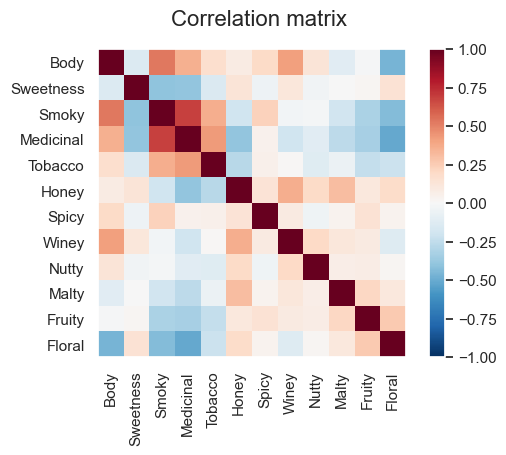

In [8]:
# Plot the correlation matrix
fig = plt.figure(figsize=(6, 4))
fig.suptitle('Correlation matrix', fontsize=16)
# Plot correlation matrix and set colorbar min and max to -1 and 1 since thats the range of the correlation coefficients
plt.imshow(correlation_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(ticks=np.arange(correlation_matrix.shape[1]), labels=list(X.columns), rotation=90)
plt.yticks(ticks=np.arange(correlation_matrix.shape[1]), labels=list(X.columns))
plt.grid(False)
plt.show()


**Assignment 2.2:** Which flavour indicators are most positively correlated? And negatively correlated? <br> Do these flavour correlations make sense to you? Why?
- *Answer (max 200 words):* 

[your answer here]

YOUR ANSWER HERE

In [9]:
with utils.marks(1, auto=False, visible=False):
    print("Manual test")

Manual test


<br>

While we can look at how the individual flavour indicators relate to each other, it is also interesting to look at how the distilleries are related to each other in terms of their flavour profiles. We can compute distances in **flavour space** between distilleries.

For example, we can compute the distance between the `Aberfeldy` distillery and every other distillery *in terms of flavour, not physical distance*. The result will be a 1D array of 86 distances. 

As you have seen in the lecture, a common distance measure is the **general Minkowski distance** also known as the **$p$-norm** or **$p$-distance**:
$$
    d_p\left(\boldsymbol{x}^\ast, \boldsymbol{x}\right) = \left( \sum_{j=1}^M \lvert x^\ast_j - x_{j}\rvert^p\right)^{\frac{1}{p}}
$$
which reduces to the cityblock (or Manhattan) distance for $p=1$ and the Euclidean distances for $p=2$:
$$
\begin{align*}
    \text{Cityblock}: \ d_1\left(\boldsymbol{x}^\ast, \boldsymbol{x}\right) = \sum_{j=1}^M \lvert x^\ast_j - x_{j}\rvert \qquad \qquad
    \text{Euclidean}: \ d_2\left(\boldsymbol{x}^\ast, \boldsymbol{x}\right) = \sqrt{\sum_{j=1}^M \lvert x^\ast_j - x_{j}\rvert^2}
\end{align*}
$$

<br>

**Assignment 2.3:** Complete the p-norm distance function in the cell below using basic numpy functions `np.sum()`and `np.abs()`
> *Hint:* Remember to think of which axis the sum should be calculated over - such that we get an array of distances. 

In [ ]:
# Assignment 2.3: Implement the p-norm distance function (this is key in many machine learning algorithms, so make sure you understand this!)
def p_norm(X_star, X, p = 2):
    """
    Compute the p-norm distance between X_star and each row in X using numpy.

    Parameters
    ----------
    x_star : np.ndarray. A 1D array of shape (M,) or a 2D array broadcastable to X.
    X : np.ndarray A 2D array of shape (N, M), where each row is a data point.
    p : int or float, optional. The order of the norm (default is 2).

    Returns: 
    np.ndarray. A 1D array of shape (N,) containing the p-norm distances.
    """
    
    # YOUR CODE HERE
    raise NotImplementedError()

    return distances

In [ ]:
with utils.marks(1, auto=False, visible=False):
    print("Manual test")

To test the implementation, we will now use the p-norm function to calculate the cityblock and euclidean distance in **flavour space**.

**Assignment 2.4:** Calculate the cityblock and euclidean distance between the Aberfeldy distillery and all of the other distilleries in the dataset - using the p_norm function. Save the results in the variables `distances_p1` and `distances_p2`.
> *Hint:* You can use the `iloc` function to select a row from the dataframe - which row is the Aberfeldy distillery in?

In [ ]:
# Assignment 2.4: Calculate distances p=1 and p=2 between the Aberfeldy and all distilleries (including itself)
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
# Visible test
with utils.marks(2):
    assert(utils.check_hash(distances_p1, ((86,), 28428.568570846488)))
    assert(utils.check_hash(distances_p2, ((86,), 11873.005164282675)))

**Assignment 2.5:** You had to implement the Cosine Similarity function in **Task 1.5** today, use it to calculate the cosine similarity between **Aberfeldy** and all whisky distilleries in the dataset - save the result in a variable called `cos_sim`.
> *Hint:* If you did not implement the Cosine Similarity function, you can find it in the solution of **Task 1.5**.

In [ ]:
# Assignment 2.5: Compute the cosine similarity between Aberfeldy and all whisky distilleries, save the result in a variable called cos_sim.
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
# Visible test
with utils.marks(1):
    assert(utils.check_hash(cos_sim, ((86,), 3221.3814891360826)))

Now that we have computed some similarities and dissimilarities, we can create a sorted plot of these:

In [ ]:
fig = plt.figure(figsize=(10, 8), dpi=150)

def rank_plot(distances, y_label = "Distance"):
    # find the ordering of the distances
    order = np.argsort(distances)
    # bar plot them
    ax.bar(np.arange(len(distances)), distances[order])
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_xticks(np.arange(86))
    ax.set_frame_on(False)
    # make sure the same order is used for the labels!
    ax.set_xticklabels(
        np.array(distilleries[np.argsort(distances)]), rotation="vertical", fontsize=8
    )


# make the plots
ax = fig.add_subplot(3, 1, 1)
ax.set_title("Manhattan/cityblock/L1 ($p=1$)", fontsize=16)
rank_plot(distances_p1)
ax = fig.add_subplot(3, 1, 2)
ax.set_title("Euclidean/L2 ($p=2$)", fontsize=16)
rank_plot(distances_p2)
ax = fig.add_subplot(3, 1, 3)
ax.set_title("Cosine Similarity", fontsize=16)
rank_plot(cos_sim, y_label="Cosine similarity")

# removes ugly overlapping
plt.tight_layout()

<br>

**Assignment 2.6:** Imagine you work in a whisky store. A customer tells you they love whiskies from **Aberfeldy**. Which whiskies would you recommend them to purchase, and which would you not recommend? Why? 

- *Answer (max 200 words):*

YOUR ANSWER HERE

In [ ]:
with utils.marks(1, auto=False, visible=False):
    print("Manual test")

<br><br>
Different geographic regions are associated with distinct flavour profiles. One of the most distinctive is the island of Islay, shown below. Owing to 
the extensive use of peat in the manufacturing process, whiskies from Islay are renowned for their bold, smoky, and unmistakable character.

<center>
  <img src="data/map.png" width="70%">
</center

We create a new boolean target variable, `y`, that tells us whether the distillery is from a **Islay**.

In [ ]:
islay_whiskies = [
    "Ardbeg",
    "Bowmore",
    "Bruichladdich",
    "Bunnahabhain",
    "Caol Ila",
    "Lagavulin",
    "Laphroaig"
]

# Boolean indicator: True if distillery is from Islay, else False
y = [d in islay_whiskies for d in distilleries]

<br>

 A new distillery opens up, and an expert whisky drinker judges the new distillery on the flavour indicators.
They judge the whisky with the following scores: 

| Body | Sweetness | Smoky | Medicinal | Tobacco | Honey | Spicy | Winey | Nutty | Malty | Fruity | Floral |
|------|-----------|-------|-----------|---------|-------|-------|-------|-------|-------|--------|--------|
| 4.0  | 1.0       | 4.0   | 3.0       | 1.0     | 0.0   | 2.0   | 0.0   | 1.0   | 1.0   | 1.0    | 0.0    |

**Assignment 2.7:** Create a new one-row pandas DataFrame, `X_new, representing the flavour profile of a new distillery, using the same attributes and column names

> *Hint:* Take inspiration from **Task 3.9**.

In [ ]:
# Assignment 2.7: Create a new data object, X_new, with the attributes given in the text.

# YOUR CODE HERE
raise NotImplementedError()

# Print the result
X_new.head()

In [ ]:
# Visible test
with utils.marks(1):
    assert(utils.check_hash(X_new, ((1, 12), 86.88443731048635)))

<br> 

**Assignment 2.8:** Initialize and train a k-nearest neighbours (kNN) classification model with $K=5$, then use it to predict whether the new distillery (`X_new`) is from Islay. Save the result as a NumPy array called `y_pred` containing a boolean value.
> *Hint:* Take inspiration from **Tasks 3.7 - 3.10**. 

> *Hint:* You do **not** need to standardize the data, as all flavour variables are on the same scale.

In [ ]:
# Assignment 2.8: Initialise, fit and predict using the KNN classifier - save the predicted label as y_pred
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
# Visible test
with utils.marks(1, auto=True, visible=True):
    assert(utils.check_hash(y_pred, ((1, ), 5.0)))

<br>

**Assignment 2.9:** We now want to find the 5 nearest distillieries in **Flavour Space**, use your model to find the indices and save their them in `closest_neighbors_indices`. 

> *Hint:* You had a very similar task in **Task 2.4**, if you had difficulty with the task, you can look at the solution file. 

> *Hint:* Once you find the indices of the closest neighbours, you can index `distilleries`, which contained the names of distilleries. 

In [ ]:
# Assignment 2.9: Find the indices of the closest neighbours to the new point and save them in "closest_neighbors_indices".

# Get the indices of the closest neighbors from the training set and save in closest_neighbors_indices
# YOUR CODE HERE
raise NotImplementedError()

# Get the closest neighbours and their names
closest_distilleries = distilleries[closest_neighbors_indices]

In [ ]:
# A test for checking the list of closest_distilleries
display(closest_distilleries)

with utils.marks(1, auto=True, visible=False):
    print("Hidden test")
    ### HIDDEN TESTS 
    # Result should be: Ardbeg, Clynelish, Caol Ila, Lagavulin, Talisker
    print("Hash of closest_distilleries:", utils._sha(sorted(list(closest_distilleries))))
    assert utils._sha(sorted(list(closest_distilleries)))=='c6c679f70ed53ca857dac265d5bc0c1c9f8b1977d9c2710854bf31deb955bc18',"List not correct"

<br>

**Assignment 2.10:** Declaration on the use of AI for solving this assignment (mandatory)

Answer by replacing *[your answer here]* with your response.
1. *I abide by [DTU's code of honour](https://student.dtu.dk/en/exam/exam-cheating/dtu-code-of-honour) and take full responsibility for the content of this submission (yes / no)*: 
    - [your answer here] 
2. *To what extent did you use generative AI to solve this assignment (0-100%)*:
    - [your answer here] 
3. *What was the primary use of generative AI, if any (writing / coding / other)*: 
    - [your answer here] 
4. *I feel I understand the key techniques/algorithms/methods/coding elements used in this exercise such that I can apply it in a **no aids** exam (yes/no)*: 
    - [your answer here] 

In [ ]:
with utils.marks(0, auto=False, visible=False):
    print("Manual test")

**Assignment 2.11:** To submit this notebook, make sure you have run everything in the **Assignment**-part, and convert this notebook to an HTML file.

> *Hint:* Open the **command palette** in Visual Studio Code, by pressing `Cmd + Shift + P` on Mac or `Ctrl + Shift + P` on Windows. 

> *Hint:* Search for `Jupyter: Export to HTML` and save the HTML file. 

> *Hint:* If you are running the notebook in the browser via the Jupyter interface, go to `File`, then `Save` and choose `Save and Export Notebook` as and select HTML.

**Assignment 2.12:** Hand in your `.ipynb` and `.HTML` file under assignments on DTU Learn for the relevant week.

**<h4>Summary of the points (only valid after rerunning the Assignment-part from scratch)</h4>**

In [ ]:
utils.marks_summary()